#Women's E-Commerce Clothing Reviews

This project is dedicated to create NLP predictor. 

We will use [Women's E-Commerce Clothing Reviews](https://) dataset from Kaggle.

This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review.

We will use these variables four our modelling:

  **Review Text:** String variable for the review body.

  **Rating:** Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

## Table of Contents

>[Women's E-Commerce Clothing Reviews](#scrollTo=b2uZqW_4efNk)

>>[Table of Contents](#scrollTo=o1hsY7YQenr4)

>>[Imports & Data Download](#scrollTo=IT47YzIJ57GE)

>>[Data Exploration](#scrollTo=DLSaNwFSfpLY)

>>[Data Preprocessing](#scrollTo=gvTWaX_ln3vH)

>>[Models using tf.hub](#scrollTo=Sj92RtRKoXBC)

>>>[nnlm-en-dim128-with-normalization_base_v1](#scrollTo=KDbCT3zUpzlJ)

>>>[Wiki-words-250-with-normalization_base_v1](#scrollTo=mDBq2d3Mp83i)

>>>[nnlm-en-dim128-with-normalization_extended_v1](#scrollTo=xe39LmwyqDwi)

>>>[Wiki-words-250-with-normalization_extended_v1](#scrollTo=MtggyifUqbvQ)

>>>[nnlm-en-dim128-with-normalization_base_v2](#scrollTo=XHZ3eMseqvhl)

>>>[nnlm-en-dim128-with-normalization_base_v4](#scrollTo=_rmBP2aarMV-)

>>>[nnlm-en-dim128-with-normalization_extended_v2](#scrollTo=l3NmPNLMr28Z)

>>[Models using LSTM, 1d Conv, Hybrid](#scrollTo=Yh6mr56rvZUs)

>>>[Bidirectional LSTM - Emb256 2xBidLSTM256 Dropout 0.5 0.5](#scrollTo=s_SP_Ihx_3tv)

>>>[1d convolutional - Emb256 2xConv1D256 Dropout 0.5](#scrollTo=joXucQ1WAlvU)

>>>[Hybrid - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.5 0.5](#scrollTo=w2S0Wdag-Lv6)

>>>[Hybrid - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.1 0.5 - oversmpl](#scrollTo=zOQr4O3vxw-g)

>>>[Hybrid - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.1 0.5 - oversmpl, init class weights](#scrollTo=23oYCpIWS0tU)

>>>[Hybrid - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.1 0.5](#scrollTo=gyEXWjY7Zk_t)

>>[Models using Transformers](#scrollTo=UwP0Eyry0V3y)

>>>[bert-base-cased_v1](#scrollTo=dw8xxjbA1S5X)

>>>[distilbert-base-uncased_v1](#scrollTo=6bg8JuZlnibi)

>>>[bert-base-cased_v2](#scrollTo=uFzfLVgcsitG)

>>>[bert-base-cased_v3](#scrollTo=90-coDotoOOt)

>>>[distilbert-base-uncased_v2](#scrollTo=yPemSpZbLmu3)

>>>[bert-base-uncased_v1](#scrollTo=fiaZupsq28z9)

>>[Conclusion](#scrollTo=uufdqMEMSFQU)

>>>[Models using tf.hub](#scrollTo=D6E2HiteRyn7)

>>>[Models using LSTM, 1d Conv, Hybrid](#scrollTo=f-nkvaupYVLX)

>>>[Models using Transformers](#scrollTo=Sv2lW4-qaplp)

>>>[All in All](#scrollTo=poH2mDWzbJYC)



## Imports & Data Download 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
SETUP = True

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
if SETUP:
    !pip install -q -U toai==0.2.*
    !pip install -q tensorflow-gpu==2.0.0
    !pip install -q -U tensorflow_hub
    !pip install -q -U git+https://github.com/huggingface/transformers


In [0]:
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.2.7
2.0.0


In [0]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.models import save_keras_model, load_keras_model
from toai.utils import save_file, load_file
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import transformers

In [0]:
%matplotlib inline
plt.style.use('seaborn')

In [0]:
DATA_DIR = Path('./gdrive/My Drive/Projects/13_clothing_reviews/data/clothing_reviews')
TEMP_DIR = Path('./gdrive/My Drive/Projects/13_clothing_reviews/temp/clothing_reviews')

In [0]:
df = pd.read_csv(DATA_DIR/'Womens Clothing E-Commerce Reviews.csv', low_memory=False)

## Data Exploration

In [0]:
df.shape

(23486, 11)

In [0]:
df.head(3).T

,0,1,2
Unnamed: 0,0,1,2
Clothing ID,767,1080,1077
Age,33,34,60
Title,NaN,NaN,Some major design flaws
Review Text,Absolutely wonderful - silky and sexy and comf...,Love this dress! it's sooo pretty. i happene...,I had such high hopes for this dress and reall...
Rating,4,5,3
Recommended IND,1,1,0
Positive Feedback Count,0,4,0
Division Name,Initmates,General,General
Department Name,Intimate,Dresses,Dresses


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [0]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,23486,NaN,NaN,NaN,11742.5,6779.97,0,5871.25,11742.5,17613.8,23485
Clothing ID,23486,NaN,NaN,NaN,918.119,203.299,0,861,936,1078,1205
Age,23486,NaN,NaN,NaN,43.1985,12.2795,18,34,41,52,99
Title,19676,13993,Love it!,136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Review Text,22641,22634,Perfect fit and i've gotten so many compliment...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,23486,NaN,NaN,NaN,4.19603,1.11003,1,4,5,5,5
Recommended IND,23486,NaN,NaN,NaN,0.822362,0.382216,0,1,1,1,1
Positive Feedback Count,23486,NaN,NaN,NaN,2.53594,5.7022,0,0,1,3,122
Division Name,23472,3,General,13850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department Name,23472,6,Tops,10468,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df.sample(5).T

,1253,12181,19043,15277,8010
Unnamed: 0,1253,12181,19043,15277,8010
Clothing ID,850,1075,952,875,1103
Age,52,51,45,52,29
Title,Adorable,Stylish and unique,Timeless,"Cute, but runs a little small",Beautiful summery dress
Review Text,I have received so many compliments on this to...,I bought this dress for a christmas party and ...,"Beautiful and flattering, i am a 6 across the ...","This is very cute, but i will have to size up ...",This dress is really lovely. if fits and flows...
Rating,5,5,5,4,5
Recommended IND,1,1,1,1,1
Positive Feedback Count,1,2,2,4,4
Division Name,General Petite,General,General Petite,General,General
Department Name,Tops,Dresses,Tops,Tops,Dresses


Text(0.5, 1.0, 'Rating Distribution')

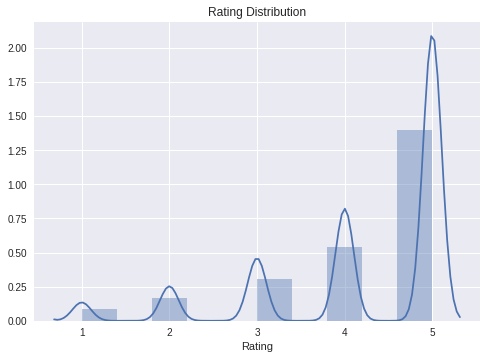

In [0]:
sns.distplot(df['Rating'], bins=10).set_title('Rating Distribution')


Text(0.5, 1.0, 'Rating Distribution')

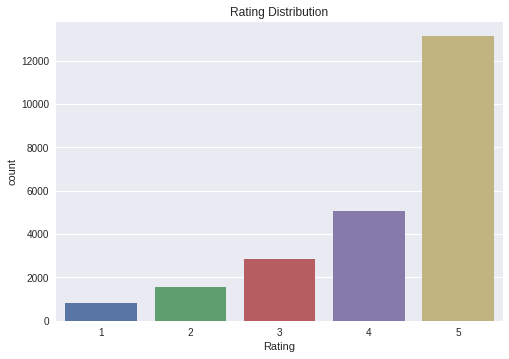

In [0]:
plt.style.use('seaborn')
sns.countplot(df['Rating']).set_title('Rating Distribution')

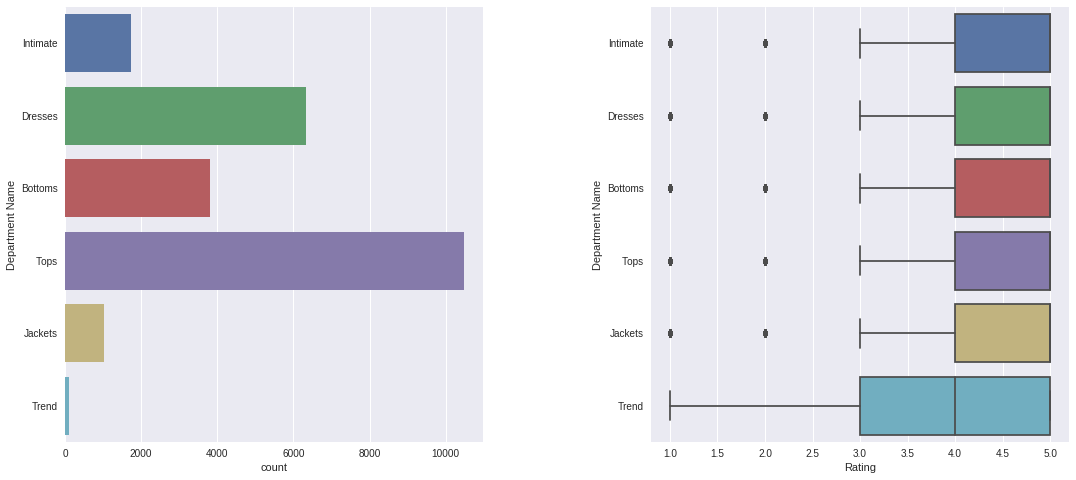

In [0]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.countplot(y='Department Name', data=df, ax=ax[0])
sns.boxplot(x='Rating',y='Department Name',data=df, ax=ax[1])
plt.subplots_adjust(wspace=0.4)

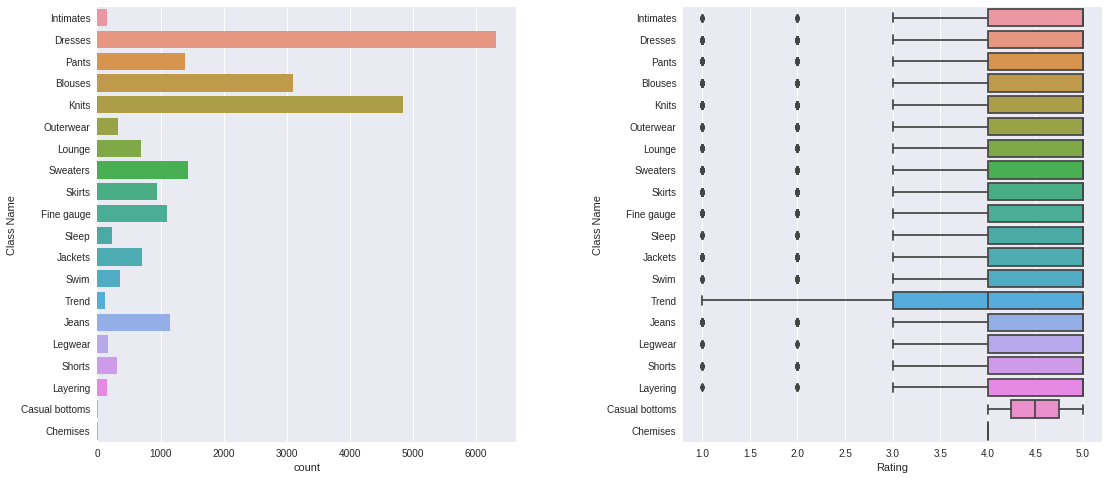

In [0]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.countplot(y='Class Name', data=df, ax=ax[0])
sns.boxplot(x='Rating',y='Class Name',data=df, ax=ax[1])
plt.subplots_adjust(wspace=0.4)

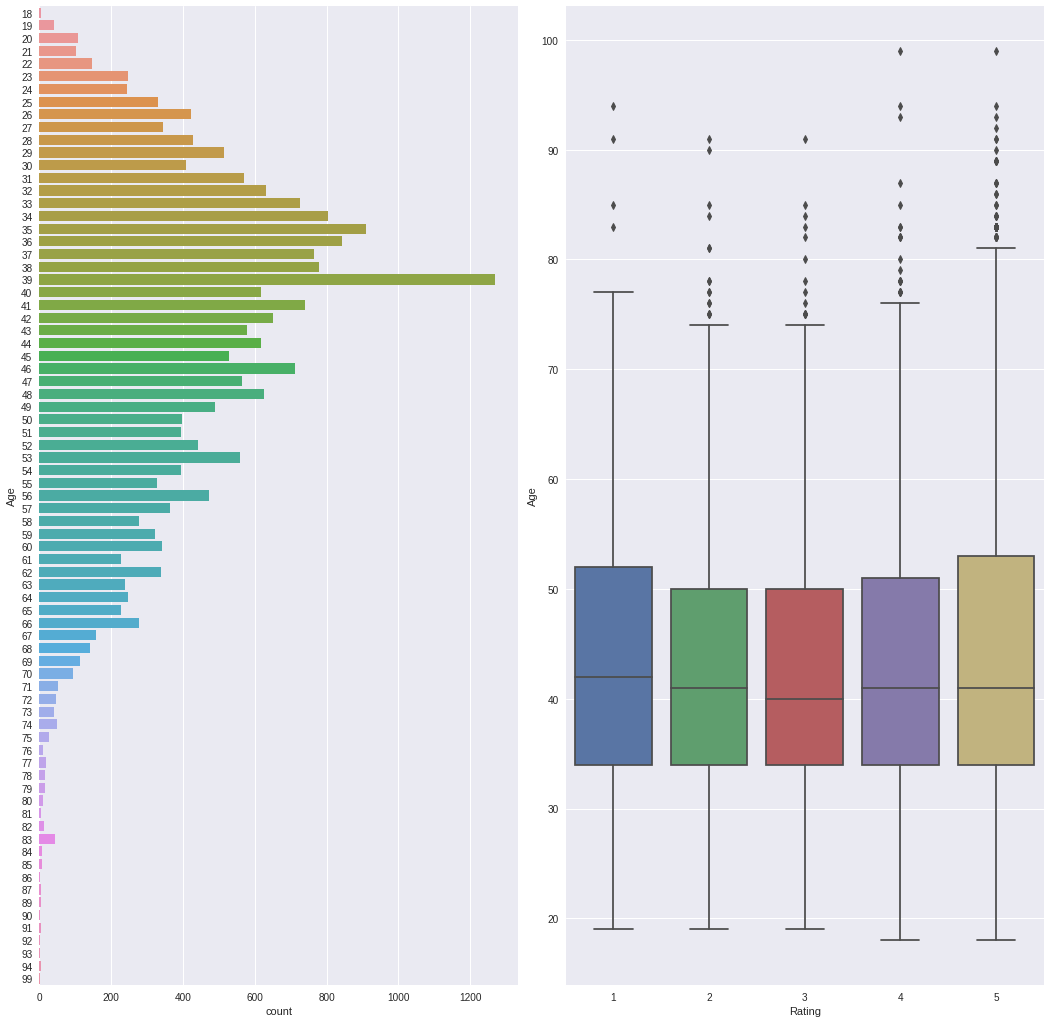

In [0]:
f, ax = plt.subplots(1, 2, figsize=(18,18))
sns.countplot(y='Age', data=df, ax=ax[0])
sns.boxplot(x='Rating',y='Age',data=df, ax=ax[1])
plt.subplots_adjust(wspace=0.1)

In [0]:
# Number od characters
df['Review Text'].str.len().describe()

count    22641.000000
mean       308.687911
std        143.940048
min          9.000000
25%        186.000000
50%        301.000000
75%        459.000000
max        508.000000
Name: Review Text, dtype: float64

In [0]:
# Number of words
df['review_text_word_count'] = df['Review Text'].str.split().str.len()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


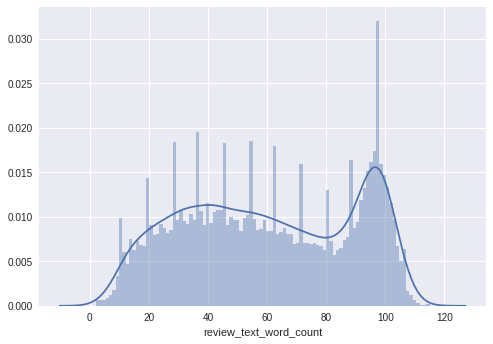

In [0]:
sns.distplot(df.review_text_word_count, bins=100)

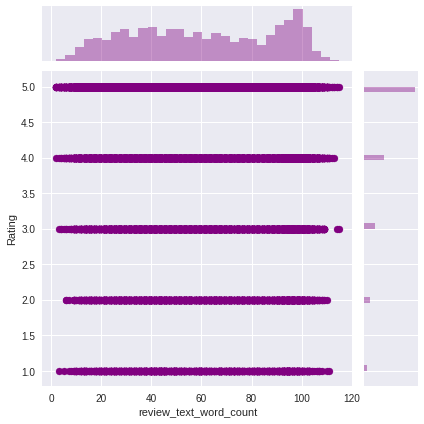

In [0]:
sns.jointplot(x="review_text_word_count", y="Rating", data=df, color='purple');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f426e8586a0>,
      dtype=object)

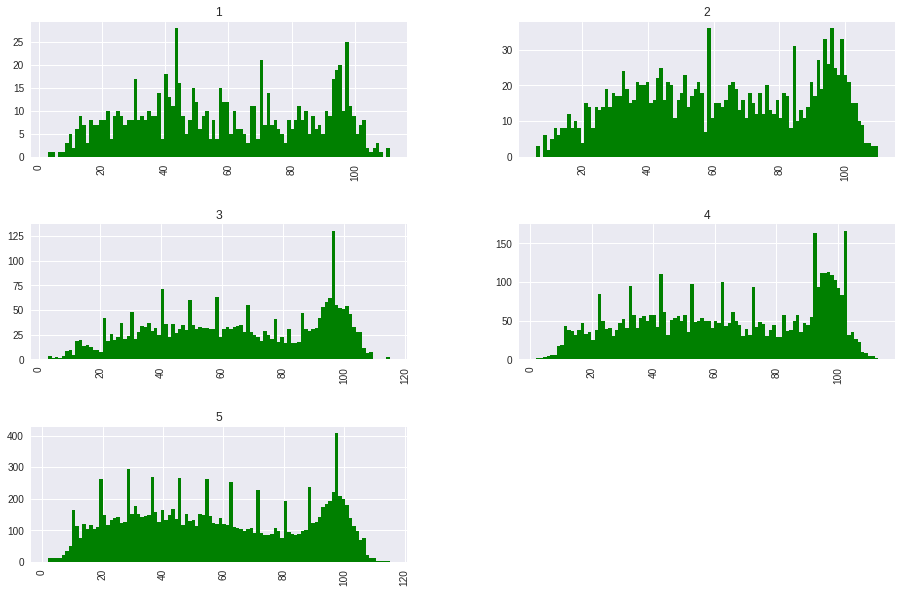

In [0]:
df.hist(column='review_text_word_count', by='Rating', bins=100, figsize=(15, 10), color='green')

In [0]:
df.review_text_word_count.value_counts()

96.0     445
95.0     413
98.0     412
99.0     408
97.0     407
        ... 
111.0      8
114.0      3
113.0      3
112.0      3
115.0      2
Name: review_text_word_count, Length: 114, dtype: int64

## Data Preprocessing

In [0]:
def make_category_map(labels) -> Dict[str, int]:
    return {x: i for i, x in enumerate(sorted(set(labels)))}

In [0]:
def init_category_map(filename, labels):
    try:
        category_map = load_file(filename)
    except:
        category_map = make_category_map(labels)
        save_file(category_map, filename)
    return category_map

In [0]:
df = df[~df["Review Text"].isna()]

In [0]:
df.to_csv(TEMP_DIR/'Womens Clothing E-Commerce Reviews_mod.csv', index=False)

In [0]:
df = pd.read_csv(TEMP_DIR/'Womens Clothing E-Commerce Reviews_mod.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22641 entries, 0 to 22640
Data columns (total 11 columns):
Unnamed: 0                 22641 non-null int64
Clothing ID                22641 non-null int64
Age                        22641 non-null int64
Title                      19675 non-null object
Review Text                22641 non-null object
Rating                     22641 non-null int64
Recommended IND            22641 non-null int64
Positive Feedback Count    22641 non-null int64
Division Name              22628 non-null object
Department Name            22628 non-null object
Class Name                 22628 non-null object
dtypes: int64(6), object(5)
memory usage: 1.9+ MB


In [0]:
category_map = init_category_map(
    TEMP_DIR / "category_map.pickle", df["Rating"].values
)

In [0]:
category_map

In [0]:
n_categories = len(category_map)

In [0]:
n_categories

5

In [0]:
df["Rating"] = df["Rating"].map(category_map)

In [0]:
df["Rating"].unique()

array([3, 4, 2, 1, 0])

In [0]:
all_data_bundle = DataBundle.from_dataframe(
    dataframe=df, x_col="Review Text", y_col="Rating"
)

In [0]:
train_data_bundle, validation_data_bundle, test_data_bundle = DataBundle.split(
    data_bundle=all_data_bundle, fracs=[0.7, 0.15, 0.15], random=False
)

In [0]:
data_container = DataContainer(
    train_data_bundle, validation_data_bundle, test_data_bundle
)

In [0]:
data_container.train.value_counts()

{0: 560, 1: 1070, 2: 1973, 3: 3394, 4: 8852}

In [0]:
data_container.validation.value_counts()

{0: 140, 1: 244, 2: 468, 3: 735, 4: 1810}

In [0]:
data_container.test.value_counts()

{0: 121, 1: 235, 2: 382, 3: 779, 4: 1878}

In [0]:
class_weights_orig = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
data_container.train = DataBundle.from_unbalanced(data_container.train)

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 0.9640952380952381,
 1: 0.9460747663551402,
 2: 1.0261530663963507,
 3: 1.1930465527401297,
 4: 0.9148666967916855}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(40492, 3397, 3395)

In [0]:
def make_dataset(data_bundle):
    return tf.data.Dataset.from_tensor_slices((data_bundle.x, data_bundle.y))

In [0]:
data_container.train.dataset = make_dataset(data_container.train)
data_container.validation.dataset = make_dataset(data_container.validation)
data_container.test.dataset = make_dataset(data_container.test)

In [0]:
data_container.train.x[0]

"3 tags sewn in, 2 small (about 1'' long) and 1 huge (about 2'' x 3''). very itchy so i cut them out. then the thread left behind was plasticy and even more itchy! how can you make an intimates item with such itchy tags? not comfortable at all! also - i love bralettes and wear them all the time including to work. i am a b cup. however, this one is so thin and flimsy that it gives no support even to a b cup - so for me this would only be a lounging bralette - if it wasn't so itchy!"

In [0]:
data_container.train.y[0]

0

## Models using tf.hub

In [0]:
def make_sentence_length_limiter(limit):
    def inner(x, y):
        return tf.strings.substr(x, 0, limit), y

    return inner

In [0]:
BATCH_SIZE = 8


In [0]:
length_limiter = make_sentence_length_limiter(400)

In [0]:
train_dataset = (
    data_container.train.dataset.repeat()
    .shuffle(len(data_container.train))
    .batch(BATCH_SIZE)
    .map(length_limiter)
    .prefetch(AUTOTUNE)
)

In [0]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(8,)
(8,)
tf.Tensor(b'I tried this on in a different retailer a couple of weeks ago... ....tried on a different one last night..same size and it looked baggy, sleeves way too long, etc.  let me add that i am usually a xs/s petite but some regular extra smalls will work also.  this was a xs reg.  even the sa could see that one looked like it fit smaller ( i showed her the photo in my phone) while this one swallowed me. ', shape=(), dtype=string)
tf.Tensor(2, shape=(), dtype=int64)


In [0]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(length_limiter)
    .prefetch(AUTOTUNE)
)

In [0]:
for x, y in validation_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(8,)
(8,)
tf.Tensor(b'The blue is a beautiful color, rather unique and it is really soft being cashmere. although, for the price i do feel it should of been a bit more "special". i also feel it\'s loose lower half feels a bit maternity. all that being said i do like the overall sweater and am keeping it as the color and feel win.', shape=(), dtype=string)
tf.Tensor(3, shape=(), dtype=int64)


In [0]:
train_dataset_steps = math.ceil(len(data_container.train) / BATCH_SIZE)

In [0]:
def train_model(
    model,
    epochs,
    lrs=None,
    optimizers=None,
    patience=5,
    verbose=1,
    log_dir=str(TEMP_DIR / "logs"),
):
    if optimizers is None:
        optimizers = [keras.optimizers.Adam(lr) for lr in lrs]
    model.layers[0].trainable = False
    model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizers[0],
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
            sparse_top_2_categorical_accuracy,
        ],
    )
    model.fit(
        train_dataset,
        steps_per_epoch=train_dataset_steps,
        validation_data=validation_dataset,
        epochs=epochs[0],
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
            keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
        ],
        class_weight=class_weights,
        verbose=verbose,
    )
    model.layers[0].trainable = True
    model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizers[1],
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
            sparse_top_2_categorical_accuracy,
        ],
    )
    model.fit(
        train_dataset,
        steps_per_epoch=train_dataset_steps,
        validation_data=validation_dataset,
        epochs=epochs[1],
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(patience=patience // 2, factor=0.3),
            keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
        ],
        class_weight=class_weights,
        verbose=verbose,
    )

In [0]:
def make_hub_model(url):
    return keras.Sequential(
        [
            hub.KerasLayer(url, dtype=tf.string, input_shape=[]),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
def make_extended_hub_model(url):
    return keras.Sequential(
        [
            hub.KerasLayer(url, dtype=tf.string, input_shape=[]),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(
                128,
                activation=keras.activations.relu,
                kernel_initializer=keras.initializers.he_uniform(),
            ),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
def run_models(urls, versions, epochs=[2,12], lrs=[1e-4, 3e-5]):
    for url in urls:
        for version in versions:
            model = version_model_map[version](url)
            model_name = f"{url.split('/')[4]}_{version}"
            print(f" {model_name} ".center(80, "="))
            shutil.rmtree(str(TEMP_DIR / model_name), ignore_errors=True)
            train_model(
                model=model,
                epochs=epochs,
                optimizers=[
                    keras.optimizers.Adam(lr=lrs[0]),
                    keras.optimizers.Adam(lr=lrs[1]),
                ],
                patience=4,
                verbose=2,
                log_dir=str(TEMP_DIR / model_name),
            )
            model.save(f"{TEMP_DIR / model_name}.h5")
            save_keras_model(
                model,
                str(TEMP_DIR / model_name / "architecture"),
                str(TEMP_DIR / model_name / "weights"),
            )
            keras.backend.clear_session()
            del model
            keras.backend.clear_session()

In [0]:
def evaluate_models(urls, versions):
    reports = {}
    for url in urls:
        for version in versions:
            model_name = f"{url.split('/')[4]}_{version}"
            print(f" {model_name} ".center(80, "="))
            try:
                model = keras.model.load_model(
                    f"{TEMP_DIR / model_name}.h5",
                    custom_objects={"KerasLayer": hub.KerasLayer},
                )
            except:
                print(f"Loading architecture & weights separately")
                model = load_keras_model(
                    str(TEMP_DIR / model_name / "architecture"),
                    str(TEMP_DIR / model_name / "weights"),
                    custom_objects={"KerasLayer": hub.KerasLayer},
                )
            reports[model_name] = classification_report(
                data_container.validation.y,
                model.predict(validation_dataset).argmax(axis=1),
            )
            del model
    return reports

### nnlm-en-dim128-with-normalization_base_v1

    epochs=[2,12],
    lrs=[1e-4, 3e-5]

In [0]:
version_model_map = {"base": make_hub_model}

In [0]:
model_urls = (
    "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
)

In [0]:
run_models(model_urls, version_model_map.keys())

==================== nnlm-en-dim128-with-normalization_base ====================
Train for 5062 steps, validate for 425 steps
Epoch 1/2
5062/5062 - 20s - loss: 1.5735 - sparse_categorical_accuracy: 0.2803 - sparse_top_2_categorical_accuracy: 0.5133 - val_loss: 1.5548 - val_sparse_categorical_accuracy: 0.3365 - val_sparse_top_2_categorical_accuracy: 0.5599
Epoch 2/2
5062/5062 - 19s - loss: 1.5293 - sparse_categorical_accuracy: 0.3226 - sparse_top_2_categorical_accuracy: 0.5625 - val_loss: 1.4541 - val_sparse_categorical_accuracy: 0.4728 - val_sparse_top_2_categorical_accuracy: 0.6832
Train for 5062 steps, validate for 425 steps
Epoch 1/12
5062/5062 - 368s - loss: 1.4397 - sparse_categorical_accuracy: 0.3831 - sparse_top_2_categorical_accuracy: 0.6438 - val_loss: 1.3322 - val_sparse_categorical_accuracy: 0.5287 - val_sparse_top_2_categorical_accuracy: 0.7545
Epoch 2/12
5062/5062 - 366s - loss: 1.3213 - sparse_categorical_accuracy: 0.4633 - sparse_top_2_categorical_accuracy: 0.7285 - val_

In [0]:
reports = evaluate_models(model_urls, version_model_map.keys())

==================== nnlm-en-dim128-with-normalization_base ====================
Loading architecture & weights separately


In [0]:
for model_name, report in reports.items():
    print(f" {model_name} ".center(80, "="))
    print(report)

==================== nnlm-en-dim128-with-normalization_base ====================
              precision    recall  f1-score   support

           0       0.30      0.31      0.31       140
           1       0.31      0.35      0.33       244
           2       0.38      0.43      0.40       468
           3       0.41      0.42      0.42       735
           4       0.82      0.77      0.79      1810

    accuracy                           0.60      3397
   macro avg       0.45      0.46      0.45      3397
weighted avg       0.61      0.60      0.61      3397



### Wiki-words-250-with-normalization_base_v1

    epochs=[2,12],
    lrs=[1e-4, 3e-5]

In [0]:
model_urls = (
    "https://tfhub.dev/google/Wiki-words-250-with-normalization/2",
)

In [0]:
run_models(model_urls, version_model_map.keys())

==================== Wiki-words-250-with-normalization_base ====================
Train for 5062 steps, validate for 425 steps
Epoch 1/2
5062/5062 - 29s - loss: 1.5931 - sparse_categorical_accuracy: 0.2643 - sparse_top_2_categorical_accuracy: 0.5044 - val_loss: 1.5027 - val_sparse_categorical_accuracy: 0.4851 - val_sparse_top_2_categorical_accuracy: 0.6756
Epoch 2/2
5062/5062 - 28s - loss: 1.5578 - sparse_categorical_accuracy: 0.2901 - sparse_top_2_categorical_accuracy: 0.5302 - val_loss: 1.3793 - val_sparse_categorical_accuracy: 0.5346 - val_sparse_top_2_categorical_accuracy: 0.7368
Train for 5062 steps, validate for 425 steps
Epoch 1/12
5062/5062 - 1129s - loss: 1.4623 - sparse_categorical_accuracy: 0.3587 - sparse_top_2_categorical_accuracy: 0.6188 - val_loss: 1.3204 - val_sparse_categorical_accuracy: 0.5434 - val_sparse_top_2_categorical_accuracy: 0.7748
Epoch 2/12
5062/5062 - 1128s - loss: 1.3264 - sparse_categorical_accuracy: 0.4545 - sparse_top_2_categorical_accuracy: 0.7156 - va

In [0]:
reports = evaluate_models(model_urls, version_model_map.keys())

==================== Wiki-words-250-with-normalization_base ====================
Loading architecture & weights separately


In [0]:
for model_name, report in reports.items():
    print(f" {model_name} ".center(80, "="))
    print(report)

==================== Wiki-words-250-with-normalization_base ====================
              precision    recall  f1-score   support

           0       0.28      0.28      0.28       140
           1       0.27      0.32      0.29       244
           2       0.35      0.41      0.37       468
           3       0.40      0.39      0.39       735
           4       0.82      0.77      0.79      1810

    accuracy                           0.58      3397
   macro avg       0.42      0.43      0.43      3397
weighted avg       0.60      0.58      0.59      3397



### nnlm-en-dim128-with-normalization_extended_v1

    epochs=[2,12],
    lrs=[1e-4, 3e-5]

In [0]:
version_model_map = {"extended": make_extended_hub_model}

In [0]:
model_urls = (
    "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
)

In [0]:
run_models(model_urls, version_model_map.keys())

================== nnlm-en-dim128-with-normalization_extended ==================
Train for 5062 steps, validate for 425 steps
Epoch 1/2
5062/5062 - 27s - loss: 1.5700 - sparse_categorical_accuracy: 0.2816 - sparse_top_2_categorical_accuracy: 0.5224 - val_loss: 1.4090 - val_sparse_categorical_accuracy: 0.5314 - val_sparse_top_2_categorical_accuracy: 0.7409
Epoch 2/2
5062/5062 - 27s - loss: 1.4946 - sparse_categorical_accuracy: 0.3338 - sparse_top_2_categorical_accuracy: 0.5806 - val_loss: 1.2858 - val_sparse_categorical_accuracy: 0.5437 - val_sparse_top_2_categorical_accuracy: 0.7554
Train for 5062 steps, validate for 425 steps
Epoch 1/12
5062/5062 - 578s - loss: 1.4067 - sparse_categorical_accuracy: 0.3724 - sparse_top_2_categorical_accuracy: 0.6404 - val_loss: 1.1776 - val_sparse_categorical_accuracy: 0.5640 - val_sparse_top_2_categorical_accuracy: 0.7845
Epoch 2/12
5062/5062 - 578s - loss: 1.2953 - sparse_categorical_accuracy: 0.4292 - sparse_top_2_categorical_accuracy: 0.7047 - val_

In [0]:
reports = evaluate_models(model_urls, version_model_map.keys())

================== nnlm-en-dim128-with-normalization_extended ==================
Loading architecture & weights separately


In [0]:
for model_name, report in reports.items():
    print(f" {model_name} ".center(80, "="))
    print(report)

================== nnlm-en-dim128-with-normalization_extended ==================
              precision    recall  f1-score   support

           0       0.33      0.34      0.33       140
           1       0.31      0.31      0.31       244
           2       0.35      0.43      0.39       468
           3       0.42      0.34      0.38       735
           4       0.79      0.80      0.80      1810

    accuracy                           0.60      3397
   macro avg       0.44      0.45      0.44      3397
weighted avg       0.60      0.60      0.60      3397



### Wiki-words-250-with-normalization_extended_v1

    epochs=[2,12],
    lrs=[1e-4, 3e-5]

In [0]:
model_urls = (
    "https://tfhub.dev/google/Wiki-words-250-with-normalization/2",
)

In [0]:
run_models(model_urls, version_model_map.keys())

================== Wiki-words-250-with-normalization_extended ==================
Train for 5062 steps, validate for 425 steps
Epoch 1/2
5062/5062 - 29s - loss: 1.5917 - sparse_categorical_accuracy: 0.2675 - sparse_top_2_categorical_accuracy: 0.5002 - val_loss: 1.5087 - val_sparse_categorical_accuracy: 0.5219 - val_sparse_top_2_categorical_accuracy: 0.7418
Epoch 2/2
5062/5062 - 28s - loss: 1.5533 - sparse_categorical_accuracy: 0.2881 - sparse_top_2_categorical_accuracy: 0.5267 - val_loss: 1.4232 - val_sparse_categorical_accuracy: 0.5225 - val_sparse_top_2_categorical_accuracy: 0.7356
Train for 5062 steps, validate for 425 steps
Epoch 1/12
5062/5062 - 1128s - loss: 1.4743 - sparse_categorical_accuracy: 0.3305 - sparse_top_2_categorical_accuracy: 0.5989 - val_loss: 1.2813 - val_sparse_categorical_accuracy: 0.5287 - val_sparse_top_2_categorical_accuracy: 0.7524
Epoch 2/12
5062/5062 - 1128s - loss: 1.3527 - sparse_categorical_accuracy: 0.3920 - sparse_top_2_categorical_accuracy: 0.6779 - va

In [0]:
reports = evaluate_models(model_urls, version_model_map.keys())

================== Wiki-words-250-with-normalization_extended ==================
Loading architecture & weights separately


In [0]:
for model_name, report in reports.items():
    print(f" {model_name} ".center(80, "="))
    print(report)

================== Wiki-words-250-with-normalization_extended ==================
              precision    recall  f1-score   support

           0       0.37      0.36      0.36       140
           1       0.30      0.36      0.33       244
           2       0.34      0.36      0.35       468
           3       0.39      0.25      0.31       735
           4       0.77      0.85      0.81      1810

    accuracy                           0.60      3397
   macro avg       0.43      0.44      0.43      3397
weighted avg       0.58      0.60      0.58      3397



### nnlm-en-dim128-with-normalization_base_v2

Changing hyperparameters to:

    epochs=[10,15],
    lrs=[1e-5, 3e-6]

In [0]:
version_model_map = {"base_version2": make_hub_model}

In [0]:
model_urls = (
    "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
)

In [0]:
run_models(model_urls, version_model_map.keys(), epochs=[10,15], lrs=[1e-5, 3e-6])

=============== nnlm-en-dim128-with-normalization_base_version2 ================
Train for 5062 steps, validate for 425 steps
Epoch 1/10
5062/5062 - 27s - loss: 1.6424 - sparse_categorical_accuracy: 0.2089 - sparse_top_2_categorical_accuracy: 0.4128 - val_loss: 1.6919 - val_sparse_categorical_accuracy: 0.1136 - val_sparse_top_2_categorical_accuracy: 0.2264
Epoch 2/10
5062/5062 - 26s - loss: 1.6346 - sparse_categorical_accuracy: 0.2102 - sparse_top_2_categorical_accuracy: 0.4156 - val_loss: 1.6708 - val_sparse_categorical_accuracy: 0.1195 - val_sparse_top_2_categorical_accuracy: 0.2570
Epoch 3/10
5062/5062 - 26s - loss: 1.6285 - sparse_categorical_accuracy: 0.2168 - sparse_top_2_categorical_accuracy: 0.4230 - val_loss: 1.6425 - val_sparse_categorical_accuracy: 0.1584 - val_sparse_top_2_categorical_accuracy: 0.3268
Epoch 4/10
5062/5062 - 26s - loss: 1.6206 - sparse_categorical_accuracy: 0.2216 - sparse_top_2_categorical_accuracy: 0.4328 - val_loss: 1.6147 - val_sparse_categorical_accurac

In [0]:
reports = evaluate_models(model_urls, version_model_map.keys())

=============== nnlm-en-dim128-with-normalization_base_version2 ================
Loading architecture & weights separately


In [0]:
for model_name, report in reports.items():
    print(f" {model_name} ".center(80, "="))
    print(report)

=============== nnlm-en-dim128-with-normalization_base_version2 ================
              precision    recall  f1-score   support

           0       0.21      0.40      0.28       140
           1       0.24      0.42      0.30       244
           2       0.28      0.32      0.30       468
           3       0.46      0.07      0.11       735
           4       0.74      0.84      0.79      1810

    accuracy                           0.55      3397
   macro avg       0.39      0.41      0.36      3397
weighted avg       0.56      0.55      0.52      3397



### nnlm-en-dim128-with-normalization_base_v4

Increasing train data.

Using class_weights of initial train dataset.

    epochs=[20,20]
    lrs=[1e-4, 3e-5]

In [0]:
train_data_bundle, validation_data_bundle, test_data_bundle = DataBundle.split(
    data_bundle=all_data_bundle, fracs=[0.8, 0.1, 0.1], random=False
)

In [0]:
data_container = DataContainer(
    train_data_bundle, validation_data_bundle, test_data_bundle
)

In [0]:
data_container.train.value_counts()

{0: 653, 1: 1241, 2: 2278, 3: 3861, 4: 10080}

In [0]:
data_container.validation.value_counts()

{0: 89, 1: 159, 2: 280, 3: 538, 4: 1199}

In [0]:
data_container.test.value_counts()

{0: 79, 1: 149, 2: 265, 3: 509, 4: 1261}

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 5.547626339969372,
 1: 2.9190975020145045,
 2: 1.5902546093064092,
 3: 0.9382543382543382,
 4: 0.3593849206349206}

In [0]:
data_container.train = DataBundle.from_unbalanced(data_container.train)

In [0]:
data_container.train.value_counts()

{0: 9795, 1: 9928, 2: 9112, 3: 7722, 4: 10080}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(46637, 2265, 2263)

In [0]:
data_container.train.dataset = make_dataset(data_container.train)
data_container.validation.dataset = make_dataset(data_container.validation)
data_container.test.dataset = make_dataset(data_container.test)

In [0]:
train_dataset = (
    data_container.train.dataset.repeat()
    .shuffle(len(data_container.train))
    .batch(BATCH_SIZE)
    .map(length_limiter)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(length_limiter)
    .prefetch(AUTOTUNE)
)

In [0]:
train_dataset_steps = math.ceil(len(data_container.train) / BATCH_SIZE)

In [0]:
version_model_map = {"base_version4": make_hub_model}

In [0]:
model_urls = (
    "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
)

In [0]:
run_models(model_urls, version_model_map.keys(), epochs=[20,20])

=============== nnlm-en-dim128-with-normalization_base_version4 ================
Train for 5830 steps, validate for 284 steps
Epoch 1/20
5830/5830 - 20s - loss: 1.5695 - sparse_categorical_accuracy: 0.2741 - sparse_top_2_categorical_accuracy: 0.5121 - val_loss: 1.5640 - val_sparse_categorical_accuracy: 0.3086 - val_sparse_top_2_categorical_accuracy: 0.5461
Epoch 2/20
5830/5830 - 20s - loss: 1.5296 - sparse_categorical_accuracy: 0.3192 - sparse_top_2_categorical_accuracy: 0.5575 - val_loss: 1.4406 - val_sparse_categorical_accuracy: 0.4985 - val_sparse_top_2_categorical_accuracy: 0.7073
Epoch 3/20
5830/5830 - 20s - loss: 1.4913 - sparse_categorical_accuracy: 0.3465 - sparse_top_2_categorical_accuracy: 0.5925 - val_loss: 1.3923 - val_sparse_categorical_accuracy: 0.5161 - val_sparse_top_2_categorical_accuracy: 0.7254
Epoch 4/20
5830/5830 - 20s - loss: 1.4660 - sparse_categorical_accuracy: 0.3670 - sparse_top_2_categorical_accuracy: 0.6131 - val_loss: 1.3493 - val_sparse_categorical_accurac

In [0]:
reports = evaluate_models(model_urls, version_model_map.keys())

=============== nnlm-en-dim128-with-normalization_base_version4 ================
Loading architecture & weights separately


In [0]:
for model_name, report in reports.items():
    print(f" {model_name} ".center(80, "="))
    print(report)

=============== nnlm-en-dim128-with-normalization_base_version4 ================
              precision    recall  f1-score   support

           0       0.33      0.36      0.34        89
           1       0.29      0.30      0.29       159
           2       0.33      0.42      0.37       280
           3       0.47      0.43      0.45       538
           4       0.82      0.79      0.80      1199

    accuracy                           0.61      2265
   macro avg       0.45      0.46      0.45      2265
weighted avg       0.62      0.61      0.61      2265



### nnlm-en-dim128-with-normalization_extended_v2

Using the same data preprocessing like in the model above - nnlm-en-dim128-with-normalization_base_version4.

    epochs=[5,15]
    lrs=[1e-4, 3e-5]

In [0]:
version_model_map = {"extended-v1": make_extended_hub_model}

In [0]:
model_urls = (
    "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
)

In [0]:
run_models(model_urls, version_model_map.keys())

================ nnlm-en-dim128-with-normalization_extended-v1 =================
Train for 5830 steps, validate for 284 steps
Epoch 1/2
5830/5830 - 31s - loss: 1.5756 - sparse_categorical_accuracy: 0.2794 - sparse_top_2_categorical_accuracy: 0.5184 - val_loss: 1.4370 - val_sparse_categorical_accuracy: 0.5302 - val_sparse_top_2_categorical_accuracy: 0.7408
Epoch 2/2
5830/5830 - 30s - loss: 1.4983 - sparse_categorical_accuracy: 0.3298 - sparse_top_2_categorical_accuracy: 0.5767 - val_loss: 1.2846 - val_sparse_categorical_accuracy: 0.5426 - val_sparse_top_2_categorical_accuracy: 0.7731
Train for 5830 steps, validate for 284 steps
Epoch 1/12
5830/5830 - 660s - loss: 1.3971 - sparse_categorical_accuracy: 0.3740 - sparse_top_2_categorical_accuracy: 0.6468 - val_loss: 1.1791 - val_sparse_categorical_accuracy: 0.5598 - val_sparse_top_2_categorical_accuracy: 0.7960
Epoch 2/12
5830/5830 - 658s - loss: 1.2766 - sparse_categorical_accuracy: 0.4380 - sparse_top_2_categorical_accuracy: 0.7215 - val_

In [0]:
reports = evaluate_models(model_urls, version_model_map.keys())

================ nnlm-en-dim128-with-normalization_extended-v1 =================
Loading architecture & weights separately


In [0]:
for model_name, report in reports.items():
    print(f" {model_name} ".center(80, "="))
    print(report)

================ nnlm-en-dim128-with-normalization_extended-v1 =================
              precision    recall  f1-score   support

           0       0.32      0.35      0.33        89
           1       0.26      0.30      0.28       159
           2       0.32      0.35      0.33       280
           3       0.47      0.36      0.41       538
           4       0.79      0.82      0.80      1199

    accuracy                           0.60      2265
   macro avg       0.43      0.44      0.43      2265
weighted avg       0.60      0.60      0.60      2265



## Models using LSTM, 1d Conv, Hybrid

In [0]:
BATCH_SIZE = 32

In [0]:
train_data_bundle, validation_data_bundle, test_data_bundle = DataBundle.split(
    data_bundle=all_data_bundle, fracs=[0.7, 0.15, 0.15], random=False
)

In [0]:
data_container = DataContainer(
    train_data_bundle, validation_data_bundle, test_data_bundle
)

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 5.660357142857142,
 1: 2.9624299065420563,
 2: 1.6065889508362898,
 3: 0.9339422510312316,
 4: 0.35808856755535473}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(15849, 3397, 3395)

In [0]:
data_container.train.dataset = make_dataset(data_container.train)
data_container.validation.dataset = make_dataset(data_container.validation)
data_container.test.dataset = make_dataset(data_container.test)

In [0]:
data_container.train.x[0]

'Absolutely wonderful - silky and sexy and comfortable'

In [0]:
data_container.train.y[0]

3

In [0]:
def preprocess(x, y, max_length=400):
    x = tf.strings.regex_replace(x, rb"<br\s*/?>", b" ")
    x = tf.strings.regex_replace(x, b"[^a-zA-Z']", b" ")
    x = tf.strings.split(x)
    x = x[:, :max_length]
    return x.to_tensor(default_value=b"<pad>"), y

In [0]:
for x, y in data_container.train.dataset.batch(BATCH_SIZE).map(preprocess).take(1):
    print(x.shape)
    print(y.shape)
    print(x[4])
    print(y[4])

(32, 105)
(32,)
tf.Tensor(
[b'This' b'shirt' b'is' b'very' b'flattering' b'to' b'all' b'due' b'to'
 b'the' b'adjustable' b'front' b'tie' b'it' b'is' b'the' b'perfect'
 b'length' b'to' b'wear' b'with' b'leggings' b'and' b'it' b'is'
 b'sleeveless' b'so' b'it' b'pairs' b'well' b'with' b'any' b'cardigan'
 b'love' b'this' b'shirt' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'], shape=(105,), dtype=string)
tf.Tensor(4, 

In [0]:
def make_vocabulary(dataset):
    vocabulary = Counter()
    for x, _ in dataset.batch(BATCH_SIZE).map(preprocess):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

In [0]:
vocabulary = make_vocabulary(data_container.train.dataset)

In [0]:
# Most common words
vocabulary.most_common()[:10]

[(b'<pad>', 690736),
 (b'the', 52171),
 (b'i', 35298),
 (b'and', 34295),
 (b'a', 30120),
 (b'it', 29835),
 (b'is', 21283),
 (b'to', 17123),
 (b'this', 14986),
 (b'in', 14397)]

In [0]:
# Least common words
vocabulary.most_common()[-10:]

[(b'testy', 1),
 (b'shimmying', 1),
 (b'twee', 1),
 (b'cell', 1),
 (b'whittle', 1),
 (b'overexposure', 1),
 (b'depend', 1),
 (b'thei', 1),
 (b'Hesitated', 1),
 (b'hats', 1)]

In [0]:
len(vocabulary)

12610

In [0]:
VOCABULARY_SIZE = 10000

In [0]:
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:VOCABULARY_SIZE]
]

In [0]:
len(truncated_vocabulary)

10000

In [0]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [0]:
for word in b"This shirt is".split():
    print(word_to_id.get(word) or VOCABULARY_SIZE)

50
77
6


In [0]:
for word in b"This banana is".split():
    print(word_to_id.get(word) or VOCABULARY_SIZE)

50
10000
6


In [0]:
words = tf.constant(truncated_vocabulary)

In [0]:
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

In [0]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

In [0]:
n_oov_buckets = 500

In [0]:
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)

In [0]:
table.lookup(tf.constant([b"This shirt is".split()]))


<tf.Tensor: id=347549, shape=(1, 3), dtype=int64, numpy=array([[50, 77,  6]])>

In [0]:
def encode_words(x, y):
    return table.lookup(x), y

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
train_dataset = (
    data_container.train.dataset.repeat()
    .batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
test_dataset = (
    data_container.test.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 105)
(32,)
tf.Tensor(
[1164  545  911    3  630    3   69    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(105,), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


In [0]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE

In [0]:
validation_dataset_steps = len(data_container.validation) // BATCH_SIZE

In [0]:
test_dataset_steps = len(data_container.test) // BATCH_SIZE

### Bidirectional LSTM - Emb256 2xBidLSTM256 Dropout 0.5 0.5

In [0]:
def make_sequential_lstm_model(
    n_categories, embedding_size, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
model = make_sequential_lstm_model(
    n_categories=n_categories,
    embedding_size=256,
    lstm_size=256,
    lstm_dropout=0.5,
    dropout=0.5,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_2lstm256_emb_256_dr_05.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 495 steps, validate for 106 steps
Epoch 1/15
495/495 [==============================] - 118s 239ms/step - loss: 1.0938 - sparse_categorical_accuracy: 0.5821 - sparse_top_2_categorical_accuracy: 0.8037 - val_loss: 0.9854 - val_sparse_categorical_accuracy: 0.5940 - val_sparse_top_2_categorical_accuracy: 0.8334
Epoch 2/15
495/495 [==============================] - 97s 196ms/step - loss: 0.8930 - sparse_categorical_accuracy: 0.6295 - sparse_top_2_categorical_accuracy: 0.8614 - val_loss: 0.9337 - val_sparse_categorical_accuracy: 0.6070 - val_sparse_top_2_categorical_accuracy: 0.8426
Epoch 3/15
495/495 [==============================] - 97s 195ms/step - loss: 0.8416 - sparse_categorical_accuracy: 0.6474 - sparse_top_2_categorical_accuracy: 0.8768 - val_loss: 0.9300 - val_sparse_categorical_accuracy: 0.6117 - val_sparse_top_2_categorical_accuracy: 0.8461
Epoch 4/15
495/495 [==============================] - 100s 201ms/step - loss: 0.8044 - sparse_categorical_accuracy: 0.6598 - spars

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2688000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 512)         1050624   
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 512)         1574912   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 5,316,101
Trainable params: 5,316,101
Non-trainable params: 0
______________________________________________

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

106/106 [==============================] - 6s 59ms/step - loss: 0.9234 - sparse_categorical_accuracy: 0.6123 - sparse_top_2_categorical_accuracy: 0.8461


[0.9234453023604627, 0.6123231, 0.8461085]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.00      0.00      0.00       244
           2       0.36      0.57      0.44       468
           3       0.36      0.21      0.26       735
           4       0.74      0.92      0.82      1810

    accuracy                           0.61      3397
   macro avg       0.29      0.34      0.31      3397
weighted avg       0.52      0.61      0.56      3397



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 1d convolutional - Emb256 2xConv1D256 Dropout 0.5

In [0]:
def make_cnn_model(
    n_categories, embedding_size, conv_size, kernel_size, dropout, stride=2
):
    input_layer = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: keras.backend.not_equal(inputs, 0))(
        input_layer
    )
    embedding_layer = keras.layers.Embedding(
        VOCABULARY_SIZE + n_oov_buckets, embedding_size
    )(input_layer)
    cnn1_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(embedding_layer)
    cnn1_dropout = keras.layers.Dropout(dropout)(cnn1_layer)
    cnn2_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(cnn1_dropout)
    cnn2_dropout = keras.layers.Dropout(dropout)(cnn2_layer)
    max_pool_layer = keras.layers.GlobalMaxPool1D()(cnn2_dropout)
    dropout_layer = keras.layers.Dropout(dropout)(max_pool_layer)
    output_layer = keras.layers.Dense(
        n_categories, activation=keras.activations.softmax
    )(dropout_layer)
    return keras.Model(inputs=input_layer, outputs=output_layer)

In [0]:
model = make_cnn_model(
    n_categories=n_categories,
    embedding_size=256,
    conv_size=256,
    kernel_size=3,
    dropout=0.5,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=20,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_cnn_256_dr05.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 495 steps, validate for 106 steps
Epoch 1/20
495/495 [==============================] - 23s 46ms/step - loss: 1.2479 - sparse_categorical_accuracy: 0.5509 - sparse_top_2_categorical_accuracy: 0.7633 - val_loss: 1.3430 - val_sparse_categorical_accuracy: 0.5333 - val_sparse_top_2_categorical_accuracy: 0.7497
Epoch 2/20
495/495 [==============================] - 25s 51ms/step - loss: 1.2144 - sparse_categorical_accuracy: 0.5579 - sparse_top_2_categorical_accuracy: 0.7686 - val_loss: 1.3219 - val_sparse_categorical_accuracy: 0.5333 - val_sparse_top_2_categorical_accuracy: 0.7497
Epoch 3/20
495/495 [==============================] - 25s 50ms/step - loss: 1.1644 - sparse_categorical_accuracy: 0.5592 - sparse_top_2_categorical_accuracy: 0.7721 - val_loss: 1.2260 - val_sparse_categorical_accuracy: 0.5360 - val_sparse_top_2_categorical_accuracy: 0.7544
Epoch 4/20
495/495 [==============================] - 26s 52ms/step - loss: 1.0506 - sparse_categorical_accuracy: 0.5845 - sparse_top_

In [0]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 256)         2688000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 256)         196864    
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 256)         196864    
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0   

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

106/106 [==============================] - 1s 10ms/step - loss: 0.9786 - sparse_categorical_accuracy: 0.6047 - sparse_top_2_categorical_accuracy: 0.8261


[0.9785997406491693, 0.604658, 0.8260613]

In [0]:
model.evaluate(test_dataset, steps=test_dataset_steps)

106/106 [==============================] - 1s 10ms/step - loss: 0.9361 - sparse_categorical_accuracy: 0.6132 - sparse_top_2_categorical_accuracy: 0.8405


[0.9360947263128353, 0.6132075, 0.8405071]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.33      0.05      0.09       244
           2       0.36      0.42      0.39       468
           3       0.39      0.24      0.30       735
           4       0.71      0.92      0.80      1810

    accuracy                           0.60      3397
   macro avg       0.36      0.33      0.32      3397
weighted avg       0.53      0.60      0.55      3397



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Hybrid - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.5 0.5

In [0]:
def make_lstm_cnn_model(n_categories, embedding_size, lstm_size, conv_size, kernel_size, dropouts, stride=2):
    input_layer = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: keras.backend.not_equal(inputs, 0))(
        input_layer
    )
    embedding_layer = keras.layers.Embedding(
        VOCABULARY_SIZE + n_oov_buckets, embedding_size
    )(input_layer)
    lstm1_layer = keras.layers.Bidirectional(
        keras.layers.LSTM(lstm_size, dropout=dropouts[0], return_sequences=True)
    )(embedding_layer, mask=mask)
    lstm2_layer = keras.layers.Bidirectional(
        keras.layers.LSTM(lstm_size, dropout=dropouts[0], return_sequences=True)
    )(lstm1_layer, mask=mask)
    cnn1_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(lstm2_layer)
    cnn1_dropout = keras.layers.Dropout(dropouts[1])(cnn1_layer)
    cnn2_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(cnn1_dropout)
    cnn2_dropout = keras.layers.Dropout(dropouts[1])(cnn2_layer)
    max_pool_layer = keras.layers.GlobalMaxPool1D()(cnn2_dropout)
    dropout_layer = keras.layers.Dropout(dropouts[1])(max_pool_layer)
    output_layer = keras.layers.Dense(
        n_categories, activation=keras.activations.softmax
    )(dropout_layer)
    return keras.Model(inputs=input_layer, outputs=output_layer)

In [0]:
model = make_lstm_cnn_model(
    n_categories=n_categories,
    embedding_size=256,
    lstm_size=256,
    conv_size=256,
    kernel_size=3,
    dropouts=[0.5, 0.5],
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=12,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_lstm_cnn_256_dr05.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 495 steps, validate for 106 steps
Epoch 1/12
495/495 [==============================] - 124s 250ms/step - loss: 1.0962 - sparse_categorical_accuracy: 0.5794 - sparse_top_2_categorical_accuracy: 0.7934 - val_loss: 1.1102 - val_sparse_categorical_accuracy: 0.5849 - val_sparse_top_2_categorical_accuracy: 0.8222
Epoch 2/12
495/495 [==============================] - 102s 206ms/step - loss: 0.9143 - sparse_categorical_accuracy: 0.6261 - sparse_top_2_categorical_accuracy: 0.8537 - val_loss: 1.0483 - val_sparse_categorical_accuracy: 0.6064 - val_sparse_top_2_categorical_accuracy: 0.8411
Epoch 3/12
495/495 [==============================] - 100s 203ms/step - loss: 0.8389 - sparse_categorical_accuracy: 0.6504 - sparse_top_2_categorical_accuracy: 0.8744 - val_loss: 1.0138 - val_sparse_categorical_accuracy: 0.6079 - val_sparse_top_2_categorical_accuracy: 0.8435
Epoch 4/12
495/495 [==============================] - 98s 198ms/step - loss: 0.7863 - sparse_categorical_accuracy: 0.6708 - spar

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

106/106 [==============================] - 7s 63ms/step - loss: 0.9157 - sparse_categorical_accuracy: 0.6221 - sparse_top_2_categorical_accuracy: 0.8526


[0.9157461287840357, 0.6220519, 0.8525943]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.47      0.12      0.19       140
           1       0.38      0.14      0.20       244
           2       0.41      0.44      0.42       468
           3       0.42      0.26      0.32       735
           4       0.72      0.92      0.81      1810

    accuracy                           0.62      3397
   macro avg       0.48      0.37      0.39      3397
weighted avg       0.58      0.62      0.58      3397



### Hybrid - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.1 0.5 - oversmpl

Increasing train data.

Using oversampling of small classes.

Using class_weights of oversampled train dataset.



    epochs=[15]
    lrs=[1e-4]
    dropouts=[0.1, 0.5]

In [0]:
train_data_bundle, validation_data_bundle, test_data_bundle = DataBundle.split(
    data_bundle=all_data_bundle, fracs=[0.8, 0.1, 0.1], random=False
)

In [0]:
data_container = DataContainer(
    train_data_bundle, validation_data_bundle, test_data_bundle
)

In [0]:
data_container.train = DataBundle.from_unbalanced(data_container.train)

In [0]:
data_container.train.value_counts()

{0: 9795, 1: 9928, 2: 9112, 3: 7722, 4: 10080}

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 0.9522613578356304,
 1: 0.9395044319097502,
 2: 1.0236391571553995,
 3: 1.2078995078995078,
 4: 0.9253373015873015}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(46637, 2265, 2263)

In [0]:
data_container.train.dataset = make_dataset(data_container.train)
data_container.validation.dataset = make_dataset(data_container.validation)
data_container.test.dataset = make_dataset(data_container.test)

In [0]:
vocabulary = make_vocabulary(data_container.train.dataset)

In [0]:
len(vocabulary)

13391

In [0]:
VOCABULARY_SIZE = 10000

In [0]:
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:VOCABULARY_SIZE]
]

In [0]:
len(truncated_vocabulary)

10000

In [0]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}


In [0]:
words = tf.constant(truncated_vocabulary)

In [0]:
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

In [0]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

In [0]:
n_oov_buckets = 500

In [0]:
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)

In [0]:
train_dataset = (
    data_container.train.dataset.repeat()
    .batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
test_dataset = (
    data_container.test.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE

In [0]:
validation_dataset_steps = len(data_container.validation) // BATCH_SIZE

In [0]:
test_dataset_steps = len(data_container.test) // BATCH_SIZE

In [0]:
model = make_lstm_cnn_model(
    n_categories=n_categories,
    embedding_size=256,
    lstm_size=256,
    conv_size=256,
    kernel_size=3,
    dropouts=[0.1, 0.5],
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_lstm_cnn_256_dr01_5.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 1457 steps, validate for 70 steps
Epoch 1/15
1457/1457 [==============================] - 289s 198ms/step - loss: 0.6799 - sparse_categorical_accuracy: 0.8988 - sparse_top_2_categorical_accuracy: 0.9356 - val_loss: 2.0982 - val_sparse_categorical_accuracy: 0.5281 - val_sparse_top_2_categorical_accuracy: 0.7661
Epoch 2/15
1457/1457 [==============================] - 268s 184ms/step - loss: 0.3862 - sparse_categorical_accuracy: 0.8985 - sparse_top_2_categorical_accuracy: 0.9605 - val_loss: 2.5059 - val_sparse_categorical_accuracy: 0.5281 - val_sparse_top_2_categorical_accuracy: 0.7661
Epoch 3/15
1457/1457 [==============================] - 269s 184ms/step - loss: 0.2827 - sparse_categorical_accuracy: 0.9312 - sparse_top_2_categorical_accuracy: 0.9889 - val_loss: 2.9872 - val_sparse_categorical_accuracy: 0.5281 - val_sparse_top_2_categorical_accuracy: 0.5799
Epoch 4/15
1457/1457 [==============================] - 269s 185ms/step - loss: 0.4008 - sparse_categorical_accuracy: 0.90

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

70/70 [==============================] - 4s 59ms/step - loss: 2.0982 - sparse_categorical_accuracy: 0.5281 - sparse_top_2_categorical_accuracy: 0.7661


[2.098231497832707, 0.528125, 0.76607144]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.00      0.00      0.00       159
           2       0.00      0.00      0.00       280
           3       0.00      0.00      0.00       538
           4       0.53      1.00      0.69      1199

    accuracy                           0.53      2265
   macro avg       0.11      0.20      0.14      2265
weighted avg       0.28      0.53      0.37      2265



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Hybrid - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.1 0.5 - oversmpl, init class weights

Using class_weights of initial train dataset(before oversampling).

    epochs=[25]
    lrs=[1e-4]
    dropouts=[0.1, 0.5]

In [0]:
data_container = DataContainer(
    train_data_bundle, validation_data_bundle, test_data_bundle
)

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 5.547626339969372,
 1: 2.9190975020145045,
 2: 1.5902546093064092,
 3: 0.9382543382543382,
 4: 0.3593849206349206}

In [0]:
data_container.train = DataBundle.from_unbalanced(data_container.train)

In [0]:
data_container.train.value_counts()

{0: 9795, 1: 9928, 2: 9112, 3: 7722, 4: 10080}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(46637, 2265, 2263)

In [0]:
data_container.train.dataset = make_dataset(data_container.train)
data_container.validation.dataset = make_dataset(data_container.validation)
data_container.test.dataset = make_dataset(data_container.test)

In [0]:
vocabulary = make_vocabulary(data_container.train.dataset)

In [0]:
len(vocabulary)

13391

In [0]:
VOCABULARY_SIZE = 10000

In [0]:
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:VOCABULARY_SIZE]
]

In [0]:
len(truncated_vocabulary)

10000

In [0]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}


In [0]:
words = tf.constant(truncated_vocabulary)

In [0]:
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

In [0]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

In [0]:
n_oov_buckets = 1000

In [0]:
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)

In [0]:
train_dataset = (
    data_container.train.dataset.repeat()
    .batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
test_dataset = (
    data_container.test.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 102)
(32,)
tf.Tensor(
[2051  600    9   43  119  787  109    3  191  119  787  974  787   23
  424   15    2  106   76   57  207    1  840  697  943   11 4232    3
   77   58  424  178  101   40  197   60 4233  414   19  311  424 2051
   16  126   38   63   71    2   35 3621    3   39   76   63    1  192
 1488    7   97    2   41    5  415  733  114    8   59    6   15  147
    3  792   20    4  799  112  999   77    7    5  415  733   15   14
   27    8   33  133   29    5 1858 2300   47    4  230   15  424    0
    0    0    0    0], shape=(102,), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


In [0]:
model = make_lstm_cnn_model(
    n_categories=n_categories,
    embedding_size=256,
    lstm_size=256,
    conv_size=256,
    kernel_size=3,
    dropouts=[0.1, 0.5],
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=25,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_lstm_cnn_256_dr01_5.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 1457 steps, validate for 70 steps
Epoch 1/25
1457/1457 [==============================] - 306s 210ms/step - loss: 0.6718 - sparse_categorical_accuracy: 0.9074 - sparse_top_2_categorical_accuracy: 0.9391 - val_loss: 2.3351 - val_sparse_categorical_accuracy: 0.5281 - val_sparse_top_2_categorical_accuracy: 0.7661
Epoch 2/25
1457/1457 [==============================] - 277s 190ms/step - loss: 0.3746 - sparse_categorical_accuracy: 0.9026 - sparse_top_2_categorical_accuracy: 0.9634 - val_loss: 2.6472 - val_sparse_categorical_accuracy: 0.5281 - val_sparse_top_2_categorical_accuracy: 0.5679
Epoch 3/25
1457/1457 [==============================] - 278s 191ms/step - loss: 0.2646 - sparse_categorical_accuracy: 0.9355 - sparse_top_2_categorical_accuracy: 0.9937 - val_loss: 2.8950 - val_sparse_categorical_accuracy: 0.5281 - val_sparse_top_2_categorical_accuracy: 0.5679
Epoch 4/25
1457/1457 [==============================] - 279s 191ms/step - loss: 0.3903 - sparse_categorical_accuracy: 0.89

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

70/70 [==============================] - 4s 62ms/step - loss: 1.1414 - sparse_categorical_accuracy: 0.5634 - sparse_top_2_categorical_accuracy: 0.8004


[1.1413757477487836, 0.5633929, 0.80044645]

In [0]:
model.evaluate(test_dataset, steps=test_dataset_steps)

70/70 [==============================] - 4s 61ms/step - loss: 1.0951 - sparse_categorical_accuracy: 0.5893 - sparse_top_2_categorical_accuracy: 0.8192


[1.0951216442244394, 0.58928573, 0.8191964]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.00      0.00      0.00       159
           2       0.32      0.06      0.10       280
           3       0.27      0.33      0.30       538
           4       0.70      0.91      0.79      1199

    accuracy                           0.57      2265
   macro avg       0.26      0.26      0.24      2265
weighted avg       0.47      0.57      0.50      2265



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Hybrid - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.1 0.5

No oversampling of small classes.

Using class_weights of initial train dataset.



    epochs=[25]
    lrs=[1e-4]
    dropouts=[0.1, 0.5]

In [0]:
data_container = DataContainer(
    train_data_bundle, validation_data_bundle, test_data_bundle
)

In [0]:
data_container.train.value_counts()

{0: 653, 1: 1241, 2: 2278, 3: 3861, 4: 10080}

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 5.547626339969372,
 1: 2.9190975020145045,
 2: 1.5902546093064092,
 3: 0.9382543382543382,
 4: 0.3593849206349206}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(18113, 2265, 2263)

In [0]:
data_container.train.dataset = make_dataset(data_container.train)
data_container.validation.dataset = make_dataset(data_container.validation)
data_container.test.dataset = make_dataset(data_container.test)

In [0]:
data_container.train.x[0]

'Absolutely wonderful - silky and sexy and comfortable'

In [0]:
data_container.train.y[0]

3

In [0]:
for x, y in data_container.train.dataset.batch(BATCH_SIZE).map(preprocess).take(1):
    print(x.shape)
    print(y.shape)
    print(x[4])
    print(y[4])

(32, 105)
(32,)
tf.Tensor(
[b'This' b'shirt' b'is' b'very' b'flattering' b'to' b'all' b'due' b'to'
 b'the' b'adjustable' b'front' b'tie' b'it' b'is' b'the' b'perfect'
 b'length' b'to' b'wear' b'with' b'leggings' b'and' b'it' b'is'
 b'sleeveless' b'so' b'it' b'pairs' b'well' b'with' b'any' b'cardigan'
 b'love' b'this' b'shirt' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'], shape=(105,), dtype=string)
tf.Tensor(4, 

In [0]:
vocabulary = make_vocabulary(data_container.train.dataset)

In [0]:
len(vocabulary)

13391

In [0]:
VOCABULARY_SIZE = 10000

In [0]:
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:VOCABULARY_SIZE]
]

In [0]:
len(truncated_vocabulary)

10000

In [0]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [0]:
words = tf.constant(truncated_vocabulary)

In [0]:
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

In [0]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

In [0]:
n_oov_buckets = 500

In [0]:
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)

In [0]:
train_dataset = (
    data_container.train.dataset.repeat()
    .batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
test_dataset = (
    data_container.test.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 105)
(32,)
tf.Tensor(
[1187  540  887    3  640    3   69    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(105,), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


In [0]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE

In [0]:
validation_dataset_steps = len(data_container.validation) // BATCH_SIZE

In [0]:
test_dataset_steps = len(data_container.test) // BATCH_SIZE

In [0]:
model = make_lstm_cnn_model(
    n_categories=n_categories,
    embedding_size=256,
    lstm_size=256,
    conv_size=256,
    kernel_size=3,
    dropouts=[0.1, 0.5],
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=25,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_lstm_cnn_256_dr01_05.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 566 steps, validate for 70 steps
Epoch 1/25
566/566 [==============================] - 131s 231ms/step - loss: 1.0525 - sparse_categorical_accuracy: 0.5896 - sparse_top_2_categorical_accuracy: 0.8102 - val_loss: 1.0834 - val_sparse_categorical_accuracy: 0.5996 - val_sparse_top_2_categorical_accuracy: 0.8397
Epoch 2/25
566/566 [==============================] - 108s 191ms/step - loss: 0.8684 - sparse_categorical_accuracy: 0.6416 - sparse_top_2_categorical_accuracy: 0.8628 - val_loss: 1.0119 - val_sparse_categorical_accuracy: 0.6116 - val_sparse_top_2_categorical_accuracy: 0.8438
Epoch 3/25
566/566 [==============================] - 108s 192ms/step - loss: 0.7766 - sparse_categorical_accuracy: 0.6711 - sparse_top_2_categorical_accuracy: 0.8920 - val_loss: 0.9569 - val_sparse_categorical_accuracy: 0.6192 - val_sparse_top_2_categorical_accuracy: 0.8451
Epoch 4/25
566/566 [==============================] - 108s 191ms/step - loss: 0.7076 - sparse_categorical_accuracy: 0.7054 - spar

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

70/70 [==============================] - 4s 59ms/step - loss: 0.9265 - sparse_categorical_accuracy: 0.6076 - sparse_top_2_categorical_accuracy: 0.8518


[0.926451506784984, 0.6075893, 0.8517857]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.45      0.21      0.29        89
           1       0.33      0.25      0.29       159
           2       0.35      0.34      0.34       280
           3       0.43      0.35      0.38       538
           4       0.74      0.86      0.80      1199

    accuracy                           0.61      2265
   macro avg       0.46      0.40      0.42      2265
weighted avg       0.58      0.61      0.59      2265



## Models using Transformers

In [0]:
BATCH_SIZE = 16

In [0]:
train_data_bundle, validation_data_bundle, test_data_bundle = DataBundle.split(
    data_bundle=all_data_bundle, fracs=[0.7, 0.15, 0.15], random=False
)

In [0]:
data_container = DataContainer(
    train_data_bundle, validation_data_bundle, test_data_bundle
)

In [0]:
data_container.train.value_counts()

{0: 560, 1: 1070, 2: 1973, 3: 3394, 4: 8852}

In [0]:
data_container.validation.value_counts()

{0: 140, 1: 244, 2: 468, 3: 735, 4: 1810}

In [0]:
data_container.test.value_counts()

{0: 121, 1: 235, 2: 382, 3: 779, 4: 1878}

In [0]:
data_container.train = DataBundle.from_unbalanced(data_container.train)

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 0.9640952380952381,
 1: 0.9460747663551402,
 2: 1.0261530663963507,
 3: 1.1930465527401297,
 4: 0.9148666967916855}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(40492, 3397, 3395)

In [0]:
data_container.train.x[0]

"3 tags sewn in, 2 small (about 1'' long) and 1 huge (about 2'' x 3''). very itchy so i cut them out. then the thread left behind was plasticy and even more itchy! how can you make an intimates item with such itchy tags? not comfortable at all! also - i love bralettes and wear them all the time including to work. i am a b cup. however, this one is so thin and flimsy that it gives no support even to a b cup - so for me this would only be a lounging bralette - if it wasn't so itchy!"

In [0]:
data_container.train.y[0]

0

In [0]:
def make_bert_dataset(data_bundle, tokenizer, sequence_length):
    features = tf.data.Dataset.from_tensor_slices(
        [
            np.pad(
                tokenizer.encode(x, add_special_tokens=True),
                (0, sequence_length),
                "constant",
                constant_values=tokenizer.pad_token_id,
            )[:sequence_length]
            for x in data_bundle.x
        ]
    )
    labels = tf.data.Dataset.from_tensor_slices(data_bundle.y)
    dataset = tf.data.Dataset.zip((features, labels)).map(
        lambda x, y: (
            {
                "input_ids": x,
                "attention_mask": int(x != tokenizer.pad_token_id),
                "token_type_ids": int(x >= tokenizer.pad_token_id),
            },
            y,
        )
    )
    return dataset

In [0]:
def train_bert_model(
    model,
    epochs,
    train_dataset,
    train_dataset_steps,
    validation_dataset,
    lrs=None,
    optimizers=None,
    patience=5,
    verbose=1,
    log_dir=str(TEMP_DIR / "logs"),
):
    if optimizers is None:
        optimizers = [keras.optimizers.Adam(lr) for lr in lrs]
    model.layers[0].trainable = False
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizers[0],
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
            sparse_top_2_categorical_accuracy,
        ],
    )
    model.fit(
        train_dataset,
        steps_per_epoch=train_dataset_steps,
        validation_data=validation_dataset,
        epochs=epochs[0],
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
            keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
        ],
        class_weight=class_weights,
        verbose=verbose,
    )
    model.layers[0].trainable = True
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizers[1],
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
            sparse_top_2_categorical_accuracy,
        ],
    )
    model.fit(
        train_dataset,
        steps_per_epoch=train_dataset_steps,
        validation_data=validation_dataset,
        epochs=epochs[1],
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(patience=patience // 2, factor=0.3),
            keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
            keras.callbacks.TensorBoard(log_dir=log_dir),
        ],
        class_weight=class_weights,
        verbose=verbose,
    )

### bert-base-cased_v1

    epochs=[2, 8]
    lrs=[1e-5, 1e-6]

In [0]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE

In [0]:
config = transformers.BertConfig.from_pretrained(
    "bert-base-cased",
    num_labels=n_categories,
)

100%|██████████| 313/313 [00:00<00:00, 71232.62B/s]


In [0]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")


100%|██████████| 213450/213450 [00:00<00:00, 1071865.02B/s]


In [0]:
train_bert_dataset = (
    make_bert_dataset(data_container.train, tokenizer, 128)
    .repeat()
    .shuffle(len(data_container.train))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_bert_dataset = (
    make_bert_dataset(data_container.validation, tokenizer, 128)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
model = transformers.TFBertForSequenceClassification.from_pretrained(
    "bert-base-cased", config=config
)

100%|██████████| 526681800/526681800 [00:15<00:00, 34736548.56B/s]


In [0]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_name = "bert-base-cased_v1"

In [0]:
train_bert_model(
    model=model,
    epochs=[2, 8],
    train_dataset=train_bert_dataset,
    train_dataset_steps=train_dataset_steps,
    validation_dataset=validation_bert_dataset,
    optimizers=[keras.optimizers.Adam(lr=1e-5), keras.optimizers.Adam(lr=1e-6)],
    patience=2,
    verbose=1,
    log_dir=str(TEMP_DIR / model_name),
)

Train for 2530 steps, validate for 213 steps
Epoch 1/2
2530/2530 [==============================] - 916s 362ms/step - loss: 1.5565 - sparse_categorical_accuracy: 0.2878 - sparse_top_2_categorical_accuracy: 0.5235 - val_loss: 1.4650 - val_sparse_categorical_accuracy: 0.5122 - val_sparse_top_2_categorical_accuracy: 0.6997
Epoch 2/2
2530/2530 [==============================] - 891s 352ms/step - loss: 1.5474 - sparse_categorical_accuracy: 0.2969 - sparse_top_2_categorical_accuracy: 0.5336 - val_loss: 1.4252 - val_sparse_categorical_accuracy: 0.5216 - val_sparse_top_2_categorical_accuracy: 0.7295
Train for 2530 steps, validate for 213 steps
Epoch 1/8
2530/2530 [==============================] - 2225s 879ms/step - loss: 1.1386 - sparse_categorical_accuracy: 0.5043 - sparse_top_2_categorical_accuracy: 0.8036 - val_loss: 0.9324 - val_sparse_categorical_accuracy: 0.6197 - val_sparse_top_2_categorical_accuracy: 0.8537
Epoch 2/8
2530/2530 [==============================] - 2195s 868ms/step - loss

In [0]:
print(
    classification_report(
        data_container.validation.y,
        model.predict(validation_bert_dataset).argmax(axis=1),
    )
)

              precision    recall  f1-score   support

           0       0.39      0.55      0.46       140
           1       0.31      0.39      0.34       244
           2       0.42      0.41      0.41       468
           3       0.47      0.36      0.40       735
           4       0.83      0.86      0.84      1810

    accuracy                           0.64      3397
   macro avg       0.48      0.51      0.49      3397
weighted avg       0.64      0.64      0.64      3397



### distilbert-base-uncased_v1

    epochs=[2, 8]
    lrs=[1e-5, 1e-6]

In [0]:
config = transformers.DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=n_categories,
)

In [0]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


100%|██████████| 231508/231508 [00:00<00:00, 937552.74B/s]


In [0]:
train_bert_dataset = (
    make_bert_dataset(data_container.train, tokenizer, 128)
    .repeat()
    .shuffle(len(data_container.train))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_bert_dataset = (
    make_bert_dataset(data_container.validation, tokenizer, 128)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
model = transformers.TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", config=config
)

100%|██████████| 363423424/363423424 [00:14<00:00, 25859826.85B/s]


In [0]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  3845      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,957,317
Trainable params: 66,957,317
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_name = "distilbert-base-uncased_v1"

In [0]:
train_bert_model(
    model=model,
    epochs=[2, 8],
    train_dataset=train_bert_dataset,
    train_dataset_steps=train_dataset_steps,
    validation_dataset=validation_bert_dataset,
    optimizers=[keras.optimizers.Adam(lr=1e-5), keras.optimizers.Adam(lr=1e-6)],
    patience=2,
    verbose=1,
    log_dir=str(TEMP_DIR / model_name),
)

Train for 2530 steps, validate for 213 steps
Epoch 1/2
2530/2530 [==============================] - 436s 172ms/step - loss: 1.4867 - sparse_categorical_accuracy: 0.3399 - sparse_top_2_categorical_accuracy: 0.6123 - val_loss: 1.2458 - val_sparse_categorical_accuracy: 0.5637 - val_sparse_top_2_categorical_accuracy: 0.7775
Epoch 2/2
2530/2530 [==============================] - 425s 168ms/step - loss: 1.3380 - sparse_categorical_accuracy: 0.4363 - sparse_top_2_categorical_accuracy: 0.6984 - val_loss: 1.1233 - val_sparse_categorical_accuracy: 0.5708 - val_sparse_top_2_categorical_accuracy: 0.7860
Train for 2530 steps, validate for 213 steps
Epoch 1/8
2530/2530 [==============================] - 1090s 431ms/step - loss: 1.0897 - sparse_categorical_accuracy: 0.5195 - sparse_top_2_categorical_accuracy: 0.8063 - val_loss: 0.8769 - val_sparse_categorical_accuracy: 0.6314 - val_sparse_top_2_categorical_accuracy: 0.8552
Epoch 2/8
2530/2530 [==============================] - 1076s 425ms/step - loss

In [0]:
print(
    classification_report(
        data_container.validation.y,
        model.predict(validation_bert_dataset).argmax(axis=1),
    )
)

              precision    recall  f1-score   support

           0       0.35      0.58      0.44       140
           1       0.30      0.30      0.30       244
           2       0.41      0.41      0.41       468
           3       0.47      0.39      0.43       735
           4       0.83      0.85      0.84      1810

    accuracy                           0.64      3397
   macro avg       0.47      0.51      0.48      3397
weighted avg       0.64      0.64      0.63      3397



### bert-base-cased_v2

Increasing patience, number of epochs.

    epochs=[5, 10]
    lrs=[1e-5, 1e-6]

In [0]:
model_name = "bert-base-cased_v2"

In [0]:
train_bert_model(
    model=model,
    epochs=[5, 10],
    train_dataset=train_bert_dataset,
    train_dataset_steps=train_dataset_steps,
    validation_dataset=validation_bert_dataset,
    optimizers=[keras.optimizers.Adam(lr=1e-5), keras.optimizers.Adam(lr=1e-6)],
    patience=4,
    verbose=1,
    log_dir=str(TEMP_DIR / model_name),
)

Train for 2530 steps, validate for 213 steps
Epoch 1/5
2530/2530 [==============================] - 451s 178ms/step - loss: 1.5600 - sparse_categorical_accuracy: 0.2831 - sparse_top_2_categorical_accuracy: 0.5226 - val_loss: 1.4873 - val_sparse_categorical_accuracy: 0.5019 - val_sparse_top_2_categorical_accuracy: 0.6656
Epoch 2/5
2530/2530 [==============================] - 445s 176ms/step - loss: 1.5516 - sparse_categorical_accuracy: 0.2962 - sparse_top_2_categorical_accuracy: 0.5315 - val_loss: 1.4156 - val_sparse_categorical_accuracy: 0.5146 - val_sparse_top_2_categorical_accuracy: 0.6924
Epoch 3/5
2530/2530 [==============================] - 445s 176ms/step - loss: 1.5371 - sparse_categorical_accuracy: 0.3100 - sparse_top_2_categorical_accuracy: 0.5483 - val_loss: 1.3842 - val_sparse_categorical_accuracy: 0.5252 - val_sparse_top_2_categorical_accuracy: 0.6944
Epoch 4/5
2530/2530 [==============================] - 445s 176ms/step - loss: 1.5249 - sparse_categorical_accuracy: 0.3165 

In [0]:
print(
    classification_report(
        data_container.validation.y,
        model.predict(validation_bert_dataset).argmax(axis=1),
    )
)

              precision    recall  f1-score   support

           0       0.41      0.43      0.42       140
           1       0.34      0.38      0.36       244
           2       0.43      0.43      0.43       468
           3       0.48      0.40      0.44       735
           4       0.83      0.87      0.85      1810

    accuracy                           0.66      3397
   macro avg       0.50      0.50      0.50      3397
weighted avg       0.65      0.66      0.65      3397



### bert-base-cased_v3

Increasing train data.

Using class_weights of initial train dataset (before oversampling).

    epochs=[5, 10]
    lrs=[1e-5, 1e-6]

In [0]:
train_data_bundle, validation_data_bundle, test_data_bundle = DataBundle.split(
    data_bundle=all_data_bundle, fracs=[0.8, 0.1, 0.1], random=False
)

In [0]:
data_container = DataContainer(
    train_data_bundle, validation_data_bundle, test_data_bundle
)

In [0]:
data_container.train.value_counts()

{0: 653, 1: 1241, 2: 2278, 3: 3861, 4: 10080}

In [0]:
data_container.validation.value_counts()

{0: 89, 1: 159, 2: 280, 3: 538, 4: 1199}

In [0]:
data_container.test.value_counts()

{0: 79, 1: 149, 2: 265, 3: 509, 4: 1261}

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 5.547626339969372,
 1: 2.9190975020145045,
 2: 1.5902546093064092,
 3: 0.9382543382543382,
 4: 0.3593849206349206}

In [0]:
data_container.train = DataBundle.from_unbalanced(data_container.train)

In [0]:
data_container.train.value_counts()

{0: 9795, 1: 9928, 2: 9112, 3: 7722, 4: 10080}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(46637, 2265, 2263)

In [0]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE


In [0]:
train_bert_dataset = (
    make_bert_dataset(data_container.train, tokenizer, 128)
    .repeat()
    .shuffle(len(data_container.train))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_bert_dataset = (
    make_bert_dataset(data_container.validation, tokenizer, 128)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
test_bert_dataset = (
    make_bert_dataset(data_container.test, tokenizer, 128)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
model_name = "bert-base-cased_v3"

In [0]:
train_bert_model(
    model=model,
    epochs=[5, 10],
    train_dataset=train_bert_dataset,
    train_dataset_steps=train_dataset_steps,
    validation_dataset=validation_bert_dataset,
    optimizers=[keras.optimizers.Adam(lr=1e-5), keras.optimizers.Adam(lr=1e-6)],
    patience=4,
    verbose=1,
    log_dir=str(TEMP_DIR / model_name),
)

Train for 2914 steps, validate for 142 steps
Epoch 1/5
2914/2914 [==============================] - 336s 115ms/step - loss: 1.5536 - sparse_categorical_accuracy: 0.2868 - sparse_top_2_categorical_accuracy: 0.5239 - val_loss: 1.4790 - val_sparse_categorical_accuracy: 0.4932 - val_sparse_top_2_categorical_accuracy: 0.6901
Epoch 2/5
2914/2914 [==============================] - 320s 110ms/step - loss: 1.5461 - sparse_categorical_accuracy: 0.3035 - sparse_top_2_categorical_accuracy: 0.5373 - val_loss: 1.4009 - val_sparse_categorical_accuracy: 0.5117 - val_sparse_top_2_categorical_accuracy: 0.7227
Epoch 3/5
2914/2914 [==============================] - 319s 109ms/step - loss: 1.5320 - sparse_categorical_accuracy: 0.3158 - sparse_top_2_categorical_accuracy: 0.5524 - val_loss: 1.3806 - val_sparse_categorical_accuracy: 0.5139 - val_sparse_top_2_categorical_accuracy: 0.7311
Epoch 4/5
2914/2914 [==============================] - 319s 110ms/step - loss: 1.5202 - sparse_categorical_accuracy: 0.3239 

In [0]:
print(
    classification_report(
        data_container.validation.y,
        model.predict(validation_bert_dataset).argmax(axis=1),
    )
)

              precision    recall  f1-score   support

           0       0.47      0.57      0.52        89
           1       0.38      0.42      0.40       159
           2       0.41      0.44      0.43       280
           3       0.49      0.36      0.41       538
           4       0.80      0.86      0.83      1199

    accuracy                           0.65      2265
   macro avg       0.51      0.53      0.52      2265
weighted avg       0.64      0.65      0.64      2265



### distilbert-base-uncased_v2

Using class_weights of initial train dataset (before oversampling).

    epochs=[5, 10]
    lrs=[1e-5, 1e-6]

In [0]:
config = transformers.DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=n_categories,
)

100%|██████████| 492/492 [00:00<00:00, 160528.79B/s]


In [0]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

100%|██████████| 231508/231508 [00:00<00:00, 1194236.92B/s]


In [0]:
model = transformers.TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", config=config
)

100%|██████████| 363423424/363423424 [00:10<00:00, 34659753.97B/s]


In [0]:
model_name = "distilbert-base-uncased_v2"

In [0]:
train_bert_model(
    model=model,
    epochs=[5, 10],
    train_dataset=train_bert_dataset,
    train_dataset_steps=train_dataset_steps,
    validation_dataset=validation_bert_dataset,
    optimizers=[keras.optimizers.Adam(lr=1e-5), keras.optimizers.Adam(lr=1e-6)],
    patience=4,
    verbose=1,
    log_dir=str(TEMP_DIR / model_name),
)

Train for 2914 steps, validate for 142 steps
Epoch 1/5
2914/2914 [==============================] - 172s 59ms/step - loss: 1.4726 - sparse_categorical_accuracy: 0.3513 - sparse_top_2_categorical_accuracy: 0.6227 - val_loss: 1.2663 - val_sparse_categorical_accuracy: 0.5519 - val_sparse_top_2_categorical_accuracy: 0.7603
Epoch 2/5
2914/2914 [==============================] - 162s 56ms/step - loss: 1.3200 - sparse_categorical_accuracy: 0.4450 - sparse_top_2_categorical_accuracy: 0.7080 - val_loss: 1.1070 - val_sparse_categorical_accuracy: 0.5651 - val_sparse_top_2_categorical_accuracy: 0.7894
Epoch 3/5
2914/2914 [==============================] - 162s 56ms/step - loss: 1.2547 - sparse_categorical_accuracy: 0.4629 - sparse_top_2_categorical_accuracy: 0.7288 - val_loss: 1.0459 - val_sparse_categorical_accuracy: 0.5779 - val_sparse_top_2_categorical_accuracy: 0.8146
Epoch 4/5
2914/2914 [==============================] - 162s 56ms/step - loss: 1.2212 - sparse_categorical_accuracy: 0.4725 - sp

In [0]:
print(
    classification_report(
        data_container.validation.y,
        model.predict(validation_bert_dataset).argmax(axis=1),
    )
)

              precision    recall  f1-score   support

           0       0.39      0.48      0.43        89
           1       0.33      0.41      0.36       159
           2       0.40      0.41      0.41       280
           3       0.51      0.44      0.47       538
           4       0.82      0.82      0.82      1199

    accuracy                           0.64      2265
   macro avg       0.49      0.51      0.50      2265
weighted avg       0.64      0.64      0.64      2265



### bert-base-uncased_v1

Using class_weights of initial train dataset (before oversampling).

    epochs=[5, 10]
    lrs=[1e-5, 1e-6]

In [0]:
config = transformers.BertConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=n_categories,
)

100%|██████████| 313/313 [00:00<00:00, 128067.23B/s]


In [0]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")


100%|██████████| 231508/231508 [00:00<00:00, 865582.64B/s]


In [0]:
train_bert_dataset = (
    make_bert_dataset(data_container.train, tokenizer, 128)
    .repeat()
    .shuffle(len(data_container.train))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_bert_dataset = (
    make_bert_dataset(data_container.validation, tokenizer, 128)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
test_bert_dataset = (
    make_bert_dataset(data_container.test, tokenizer, 128)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
data_container.train.x[0]

"3 tags sewn in, 2 small (about 1'' long) and 1 huge (about 2'' x 3''). very itchy so i cut them out. then the thread left behind was plasticy and even more itchy! how can you make an intimates item with such itchy tags? not comfortable at all! also - i love bralettes and wear them all the time including to work. i am a b cup. however, this one is so thin and flimsy that it gives no support even to a b cup - so for me this would only be a lounging bralette - if it wasn't so itchy!"

In [0]:
data_container.train.y[0]

0

In [0]:
model = transformers.TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased", config=config
)

100%|██████████| 536063208/536063208 [00:18<00:00, 28931860.18B/s]


In [0]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_name = "bert-base-uncased_v1"

In [0]:
train_bert_model(
    model=model,
    epochs=[5, 10],
    train_dataset=train_bert_dataset,
    train_dataset_steps=train_dataset_steps,
    validation_dataset=validation_bert_dataset,
    optimizers=[keras.optimizers.Adam(lr=1e-5), keras.optimizers.Adam(lr=1e-6)],
    patience=4,
    verbose=1,
    log_dir=str(TEMP_DIR / model_name),
)

Train for 2914 steps, validate for 142 steps
Epoch 1/5
2914/2914 [==============================] - 332s 114ms/step - loss: 1.5642 - sparse_categorical_accuracy: 0.2789 - sparse_top_2_categorical_accuracy: 0.5181 - val_loss: 1.5270 - val_sparse_categorical_accuracy: 0.4667 - val_sparse_top_2_categorical_accuracy: 0.6362
Epoch 2/5
2914/2914 [==============================] - 315s 108ms/step - loss: 1.5632 - sparse_categorical_accuracy: 0.2828 - sparse_top_2_categorical_accuracy: 0.5147 - val_loss: 1.4742 - val_sparse_categorical_accuracy: 0.4989 - val_sparse_top_2_categorical_accuracy: 0.7263
Epoch 3/5
2914/2914 [==============================] - 316s 108ms/step - loss: 1.5522 - sparse_categorical_accuracy: 0.2981 - sparse_top_2_categorical_accuracy: 0.5327 - val_loss: 1.4327 - val_sparse_categorical_accuracy: 0.5064 - val_sparse_top_2_categorical_accuracy: 0.7196
Epoch 4/5
2914/2914 [==============================] - 316s 109ms/step - loss: 1.5421 - sparse_categorical_accuracy: 0.3107 

In [0]:
print(
    classification_report(
        data_container.validation.y,
        model.predict(validation_bert_dataset).argmax(axis=1),
    )
)

              precision    recall  f1-score   support

           0       0.39      0.48      0.43        89
           1       0.31      0.40      0.35       159
           2       0.43      0.42      0.43       280
           3       0.53      0.38      0.44       538
           4       0.81      0.87      0.84      1199

    accuracy                           0.65      2265
   macro avg       0.49      0.51      0.50      2265
weighted avg       0.64      0.65      0.64      2265



In [0]:
model.evaluate(validation_bert_dataset)

142/142 [==============================] - 14s 97ms/step - loss: 0.8458 - sparse_categorical_accuracy: 0.6490 - sparse_top_2_categorical_accuracy: 0.8883


[0.8458422951295342, 0.6490066, 0.88830024]

## Conclusion

### **Models using tf.hub**

The best macro **avg f-1score** of 0.45 was achieved by *nnlm-en-dim128-with-normalization_base_version4*:

    epochs=[20,20]
    lrs=[1e-4, 3e-5]
    oversampling
    class_weights of initial train dataset 

                  precision    recall  f1-score   support
              0       0.33      0.36      0.34        89
              1       0.29      0.30      0.29       159
              2       0.33      0.42      0.37       280
              3       0.47      0.43      0.45       538
              4       0.82      0.79      0.80      1199

        accuracy                           0.61      2265
       macro avg       0.45      0.46      0.45      2265
    weighted avg       0.62      0.61      0.61      2265

The lowest macro avg f-1score of 0.36 was achieved by *nnlm-en-dim128-with-normalization_base_v2*.

###**Models using LSTM, 1d Conv, Hybrid**

The **best macro avg f-1score** of 0.42 was achieved by *Hybrid - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.1 0.5*:

    epochs=[25]
    lrs=[1e-4]
    dropouts=[0.1, 0.5]
    no oversampling
    class_weights of initial train dataset

                  precision    recall  f1-score   support

              0       0.45      0.21      0.29        89
              1       0.33      0.25      0.29       159
              2       0.35      0.34      0.34       280
              3       0.43      0.35      0.38       538
              4       0.74      0.86      0.80      1199

        accuracy                           0.61      2265
       macro avg       0.46      0.40      0.42      2265
    weighted avg       0.58      0.61      0.59      2265


The lowest macro avg f-1score of 0.14 was achieved by model *Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.1 0.5 oversmpl*:

    oversampling
    class_weights of oversampled train dataset


###**Models using Transformers**

The best **macro avg f-1score** of 0.52 was achieved by *bert-base-cased_v3*:

    epochs=[5, 10]
    lrs=[1e-5, 1e-6]
    oversampling
    class_weights of initial train dataset


                  precision    recall  f1-score   support

              0       0.47      0.57      0.52        89
              1       0.38      0.42      0.40       159
              2       0.41      0.44      0.43       280
              3       0.49      0.36      0.41       538
              4       0.80      0.86      0.83      1199

        accuracy                           0.65      2265
       macro avg       0.51      0.53      0.52      2265
    weighted avg       0.64      0.65      0.64      2265


The lowest macro avg f-1score of 0.48 was achieved by model *distilbert-base-uncased_v1*:

    epochs=[2, 8]
    lrs=[1e-5, 1e-6]
    oversampling
    class_weights of oversampled train dataset


###**All in All**

Best results achieved using models with pretrained transformer-based architecture. We reached **macro acro avg f-1score** of 0.52.

It is significantly higher than using models without pretrained architecture, where we reached  **macro acro avg f-1score** of 0.42.

The results we got using tf.hub are better than using models without pretrained architecture. But not as good as using transformers. The best **macro acro avg f-1score** using tf.hub - 0.45.